# HVG:seurat_v3 & harmony workflow
**Author:** [Severin Dicks](https://github.com/Intron7)

To run this notebook please make sure you have a working rapids environment with all nessaray dependencies. Run the data_downloader notebook first to create the AnnData object we are working with. In this example workflow we'll be looking at a dataset of ca. 90000 cells from [Quin et al., Cell Research 2020](https://www.nature.com/articles/s41422-020-0355-0).

In [1]:
import scanpy as sc
import cupy as cp

import time
import rapids_singlecell as rsc

import warnings

warnings.filterwarnings("ignore")

In [2]:
import rmm
from rmm.allocators.cupy import rmm_cupy_allocator

rmm.reinitialize(
    managed_memory=False,  # Allows oversubscription
    pool_allocator=False,  # default is False
    devices=0,  # GPU device IDs to register. By default registers only GPU 0.
)
cp.cuda.set_allocator(rmm_cupy_allocator)

## Load and Prepare Data

We load the sparse count matrix from an `h5ad` file using Scanpy. The sparse count matrix will then be placed on the GPU. 

In [3]:
data_load_start = time.time()

In [4]:
%%time
adata = sc.read("h5/adata.raw.h5ad")

CPU times: user 2.34 s, sys: 161 ms, total: 2.5 s
Wall time: 2.55 s


In [5]:
%%time
rsc.get.anndata_to_GPU(adata)

CPU times: user 60.6 ms, sys: 204 ms, total: 265 ms
Wall time: 264 ms


In [6]:
adata.shape

(93575, 33694)

Verify the shape of the resulting sparse matrix:

In [7]:
adata.shape

(93575, 33694)

In [8]:
data_load_time = time.time()
print("Total data load and format time: %s" % (data_load_time - data_load_start))

Total data load and format time: 2.860538959503174


## Preprocessing

In [9]:
preprocess_start = time.time()

### Quality Control

We perform a basic qulitiy control and plot the results

In [10]:
%%time
rsc.pp.flag_gene_family(adata, gene_family_name="MT", gene_family_prefix="MT-")

CPU times: user 5.61 ms, sys: 276 µs, total: 5.89 ms
Wall time: 5.77 ms


In [11]:
%%time
rsc.pp.flag_gene_family(adata, gene_family_name="RIBO", gene_family_prefix="RPS")

CPU times: user 5.53 ms, sys: 0 ns, total: 5.53 ms
Wall time: 5.41 ms


In [12]:
%%time
rsc.pp.calculate_qc_metrics(adata, qc_vars=["MT", "RIBO"])

CPU times: user 91.2 ms, sys: 1.86 ms, total: 93 ms
Wall time: 167 ms


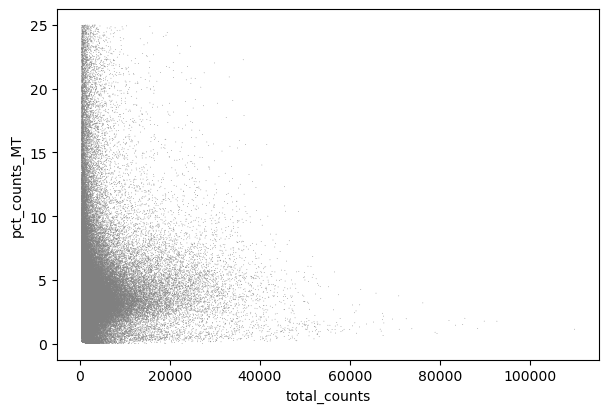

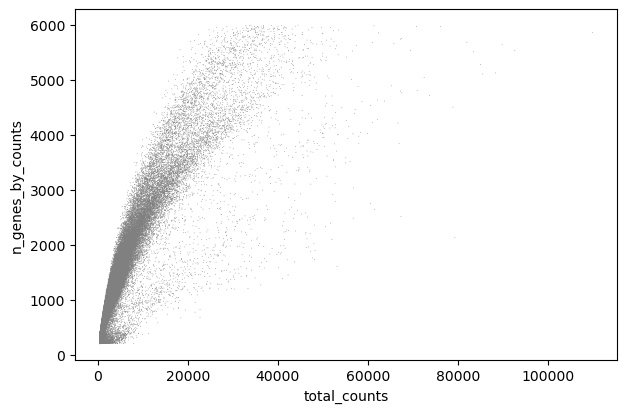

In [13]:
sc.pl.scatter(adata, x="total_counts", y="pct_counts_MT")
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")

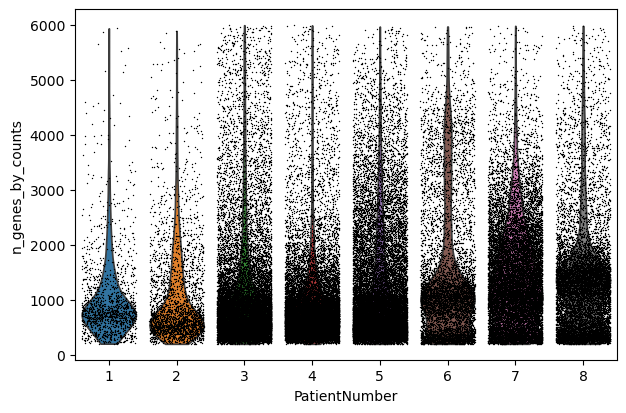

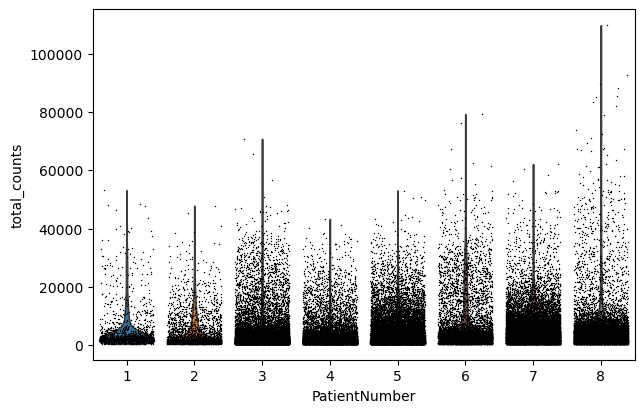

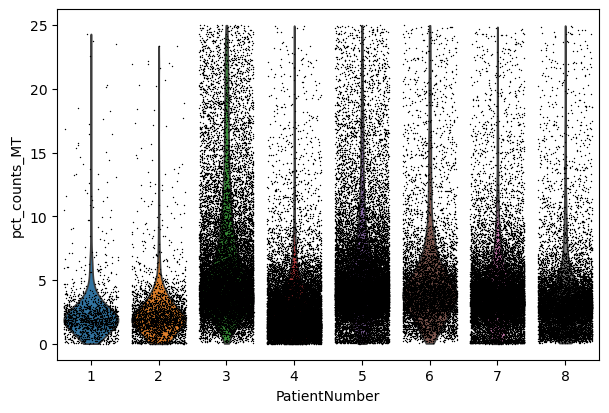

In [14]:
sc.pl.violin(adata, "n_genes_by_counts", jitter=0.4, groupby="PatientNumber")
sc.pl.violin(adata, "total_counts", jitter=0.4, groupby="PatientNumber")
sc.pl.violin(adata, "pct_counts_MT", jitter=0.4, groupby="PatientNumber")

### Filter

We filter the count matrix to remove cells with an extreme number of genes expressed.
We also filter out cells with a mitchondrial countent of more than 20%.

In [15]:
%%time
adata = adata[adata.obs["n_genes_by_counts"] > 200]
adata = adata[adata.obs["n_genes_by_counts"] < 5000]
adata.shape

CPU times: user 22.2 ms, sys: 2.92 ms, total: 25.1 ms
Wall time: 24.4 ms


(92666, 33694)

In [16]:
%%time
adata = adata[adata.obs["pct_counts_MT"] < 20]
adata.shape

CPU times: user 8.02 ms, sys: 1.76 ms, total: 9.78 ms
Wall time: 9.36 ms


(91180, 33694)

We also filter out genes that are expressed in less than 3 cells.

In [17]:
%%time
rsc.pp.filter_genes(adata, min_count=3)

filtered out 8034 genes based on n_cells_by_counts
CPU times: user 48.9 ms, sys: 29.2 ms, total: 78.1 ms
Wall time: 89.5 ms


We store the raw expression counts in the `.layer["counts"]`

In [18]:
adata.layers["counts"] = adata.X.copy()

In [19]:
adata.shape

(91180, 25660)

### Normalize

We normalize the count matrix so that the total counts in each cell sum to 1e4.

In [20]:
%%time
rsc.pp.normalize_total(adata, target_sum=1e4)

CPU times: user 232 µs, sys: 1.08 ms, total: 1.31 ms
Wall time: 6.54 ms


Next, we log transform the count matrix.

In [21]:
%%time
rsc.pp.log1p(adata)

CPU times: user 891 µs, sys: 832 µs, total: 1.72 ms
Wall time: 1.66 ms


### Select Most Variable Genes

Now we search for highly variable genes. This function only supports the flavors `cell_ranger` `seurat` `seurat_v3` and `pearson_residuals`. As you can in scanpy you can filter based on cutoffs or select the top n cells. You can also use a `batch_key` to reduce batcheffects.

In this example we use `seurat_v3` for selecting highly variable genes based on the raw counts in `.layer["counts"]`

In [22]:
%%time
rsc.pp.highly_variable_genes(
    adata,
    n_top_genes=5000,
    flavor="seurat_v3",
    batch_key="PatientNumber",
    layer="counts",
)

CPU times: user 1.12 s, sys: 4.09 s, total: 5.21 s
Wall time: 633 ms


Now we safe this version of the AnnData as adata.raw.

In [23]:
%%time
adata.raw = adata

CPU times: user 77 ms, sys: 49.1 ms, total: 126 ms
Wall time: 125 ms


Now we restrict our AnnData object to the highly variable genes.

In [24]:
%%time
adata = adata[:, adata.var["highly_variable"]]

CPU times: user 57.1 ms, sys: 53.2 ms, total: 110 ms
Wall time: 110 ms


In [25]:
adata.shape

(91180, 5000)

Next we regress out effects of counts per cell and the mitochondrial content of the cells. As you can with scanpy you can use every numerical column in `.obs` for this.

In [26]:
%%time
rsc.pp.regress_out(adata, keys=["total_counts", "pct_counts_MT"])

CPU times: user 650 ms, sys: 794 ms, total: 1.44 s
Wall time: 1.48 s


### Scale

Finally, we scale the count matrix to obtain a z-score and apply a cutoff value of 10 standard deviations.

In [27]:
%%time
rsc.pp.scale(adata, max_value=10)

CPU times: user 28.7 ms, sys: 4.05 ms, total: 32.8 ms
Wall time: 43.6 ms


### Principal component analysis

We use PCA to reduce the dimensionality of the matrix to its top 100 principal components. We use the PCA implementation from cuMLs.

In [28]:
%%time
rsc.pp.pca(adata, n_comps=100)

CPU times: user 692 ms, sys: 78.3 ms, total: 770 ms
Wall time: 780 ms


We can use scanpy `pca_variance_ratio` plot to inspect the contribution of single PCs to the total variance in the data.

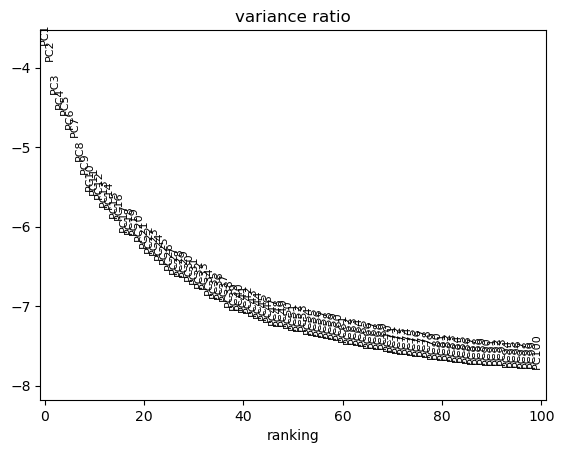

In [29]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=100)

Now we move `.X` and `.layers` out of the GPU.

In [30]:
%%time
rsc.get.anndata_to_CPU(adata, convert_all=True)

CPU times: user 149 ms, sys: 133 ms, total: 282 ms
Wall time: 282 ms


In [31]:
preprocess_time = time.time()
print("Total Preprocessing time: %s" % (preprocess_time - preprocess_start))

Total Preprocessing time: 7.828192234039307


We have now finished the preprocessing of the data.

## Batch Correction

In [32]:
%%time
rsc.pp.harmony_integrate(adata, key="PatientNumber")

2024-01-03 17:01:31,700 - harmonypy_gpu - INFO - Iteration 1 of 10
2024-01-03 17:01:34,004 - harmonypy_gpu - INFO - Iteration 2 of 10
2024-01-03 17:01:36,285 - harmonypy_gpu - INFO - Iteration 3 of 10
2024-01-03 17:01:38,569 - harmonypy_gpu - INFO - Iteration 4 of 10
2024-01-03 17:01:40,370 - harmonypy_gpu - INFO - Iteration 5 of 10
2024-01-03 17:01:41,689 - harmonypy_gpu - INFO - Iteration 6 of 10
2024-01-03 17:01:43,397 - harmonypy_gpu - INFO - Iteration 7 of 10
2024-01-03 17:01:44,625 - harmonypy_gpu - INFO - Iteration 8 of 10
2024-01-03 17:01:46,433 - harmonypy_gpu - INFO - Converged after 8 iterations


CPU times: user 6.58 s, sys: 8.26 s, total: 14.8 s
Wall time: 15 s


## Clustering and Visualization

### Computing the neighborhood graph and UMAP

Next we compute the neighborhood graph using rsc.

Scanpy CPU implementation of nearest neighbor uses an approximation, while the GPU version calculates the exact graph. Both methods are valid, but you might see differences.

In [33]:
%%time
rsc.pp.neighbors(adata, n_neighbors=15, n_pcs=40)

CPU times: user 241 ms, sys: 28 ms, total: 269 ms
Wall time: 271 ms


Next we calculate the UMAP embedding using rapdis.

In [34]:
%%time
rsc.tl.umap(adata)

CPU times: user 248 ms, sys: 17.9 ms, total: 266 ms
Wall time: 266 ms


### Clustering

Next, we use the Louvain and Leiden algorithm for graph-based clustering.

In [35]:
%%time
rsc.tl.louvain(adata, resolution=0.6)

CPU times: user 3.37 s, sys: 698 ms, total: 4.07 s
Wall time: 5.94 s


In [36]:
%%time
rsc.tl.leiden(adata, resolution=0.6)

CPU times: user 386 ms, sys: 449 ms, total: 834 ms
Wall time: 835 ms


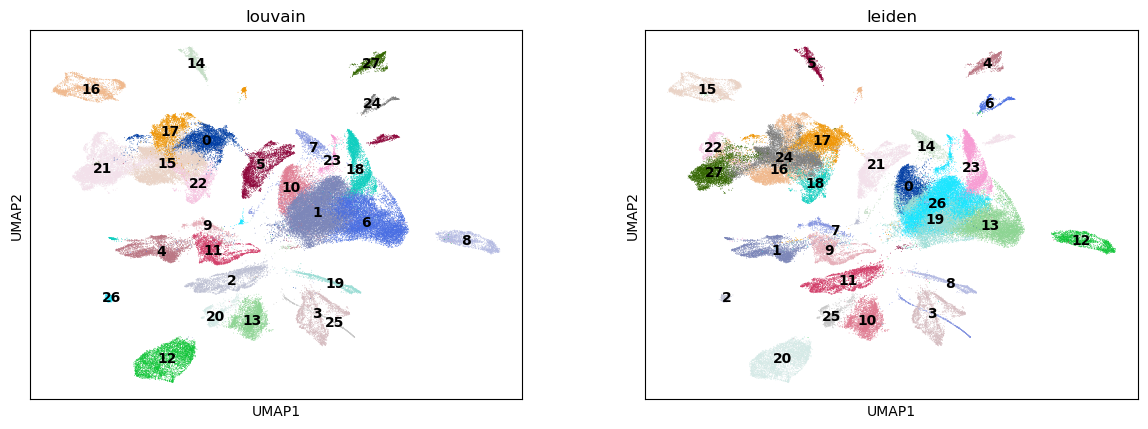

CPU times: user 568 ms, sys: 157 ms, total: 725 ms
Wall time: 547 ms


In [37]:
%%time
sc.pl.umap(adata, color=["louvain", "leiden"], legend_loc="on data")

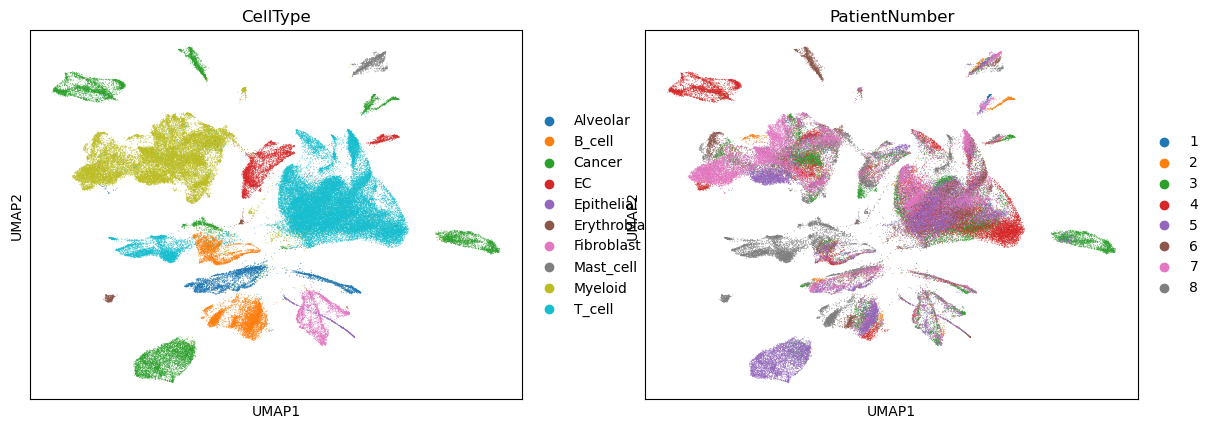

In [38]:
sc.pl.umap(adata, color=["CellType", "PatientNumber"])

We also calculate the embedding density in the UMAP using cuML

In [39]:
%%time
rsc.tl.embedding_density(adata, groupby="PatientNumber")

CPU times: user 479 ms, sys: 58.3 ms, total: 538 ms
Wall time: 585 ms


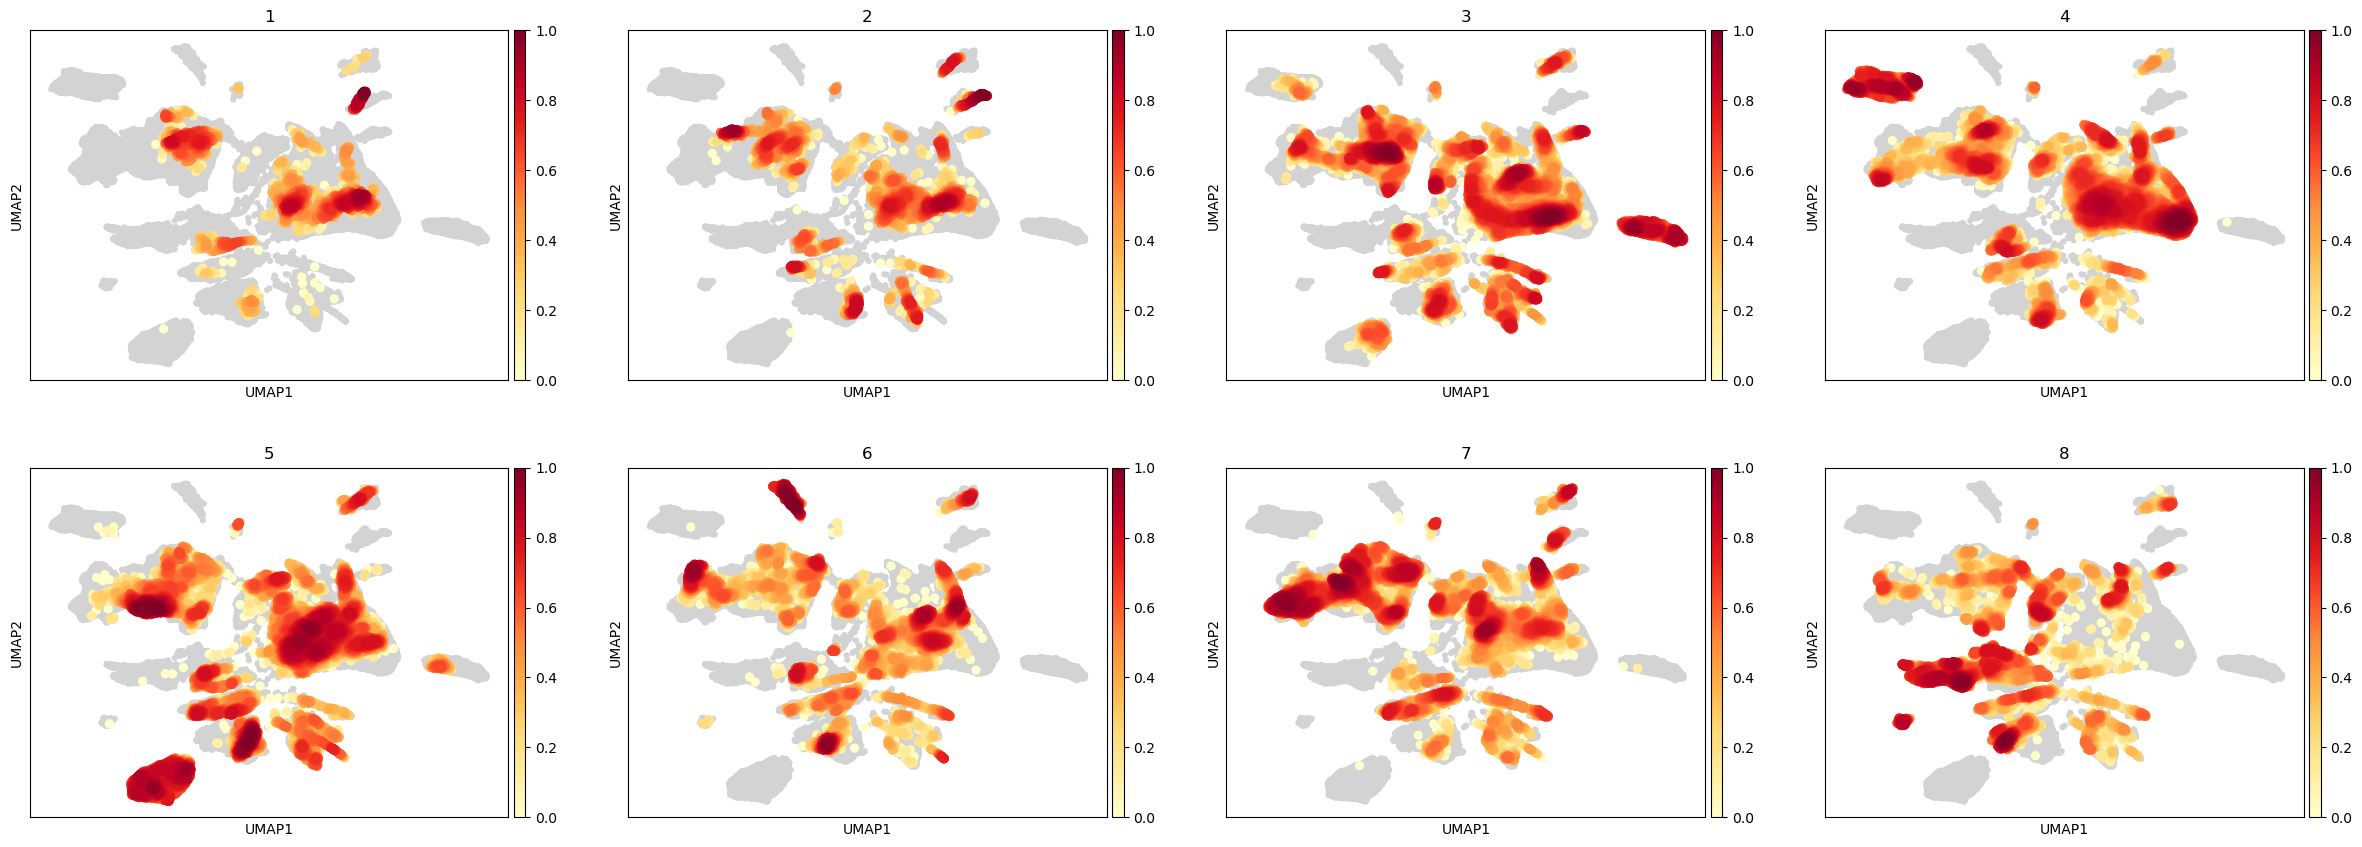

In [40]:
sc.pl.embedding_density(adata, groupby="PatientNumber")

### TSNE + k-Means

Next we use TSNE on the GPU to visualize the cells in two dimensions. We also perform k-Means clustering of the cells into 8 clusters.

In [41]:
%%time
rsc.tl.tsne(adata, n_pcs=40)

[W] [17:01:58.411749] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
CPU times: user 1.25 s, sys: 1.41 s, total: 2.66 s
Wall time: 2.66 s


In [42]:
rsc.tl.kmeans(adata, n_clusters=8)

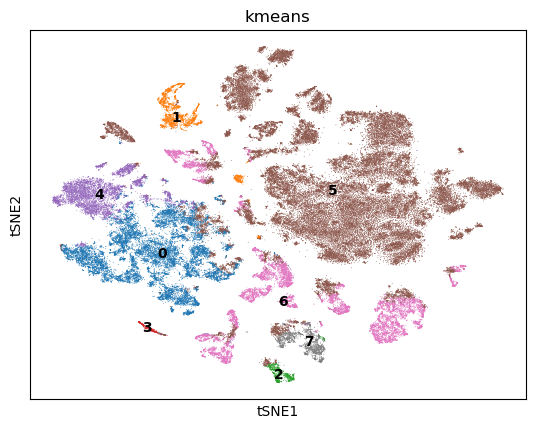

CPU times: user 291 ms, sys: 162 ms, total: 453 ms
Wall time: 271 ms


In [43]:
%%time
sc.pl.tsne(adata, color=["kmeans"], legend_loc="on data")

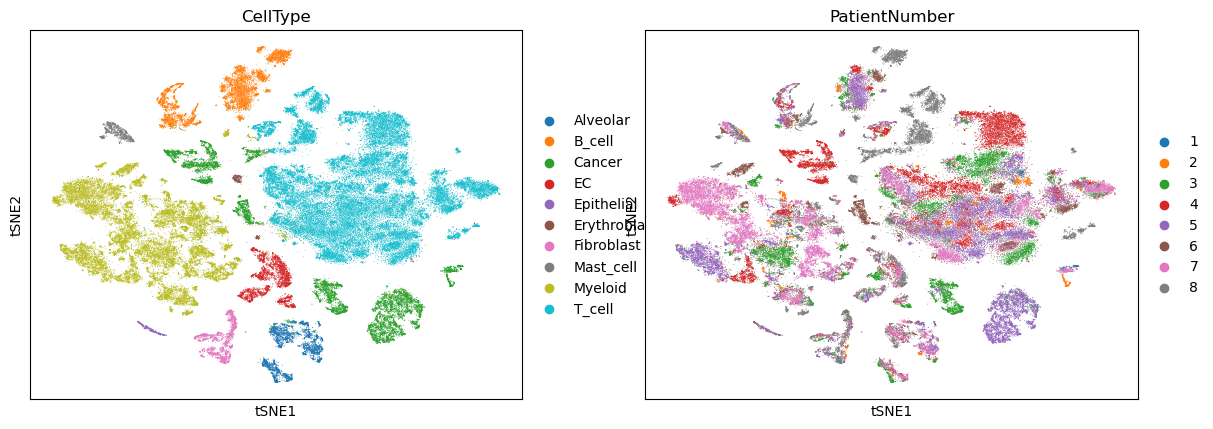

In [44]:
sc.pl.tsne(adata, color=["CellType", "PatientNumber"])

## Differential expression analysis

We now use logistic regression to compute a ranking for highly differential genes in each Louvain cluster.

We use logistic regression to identify the top 50 genes distinguishing each cluster.

In [45]:
%%time
rsc.tl.rank_genes_groups_logreg(adata, groupby="CellType", use_raw=False)

CPU times: user 2.42 s, sys: 1.06 s, total: 3.49 s
Wall time: 3.52 s


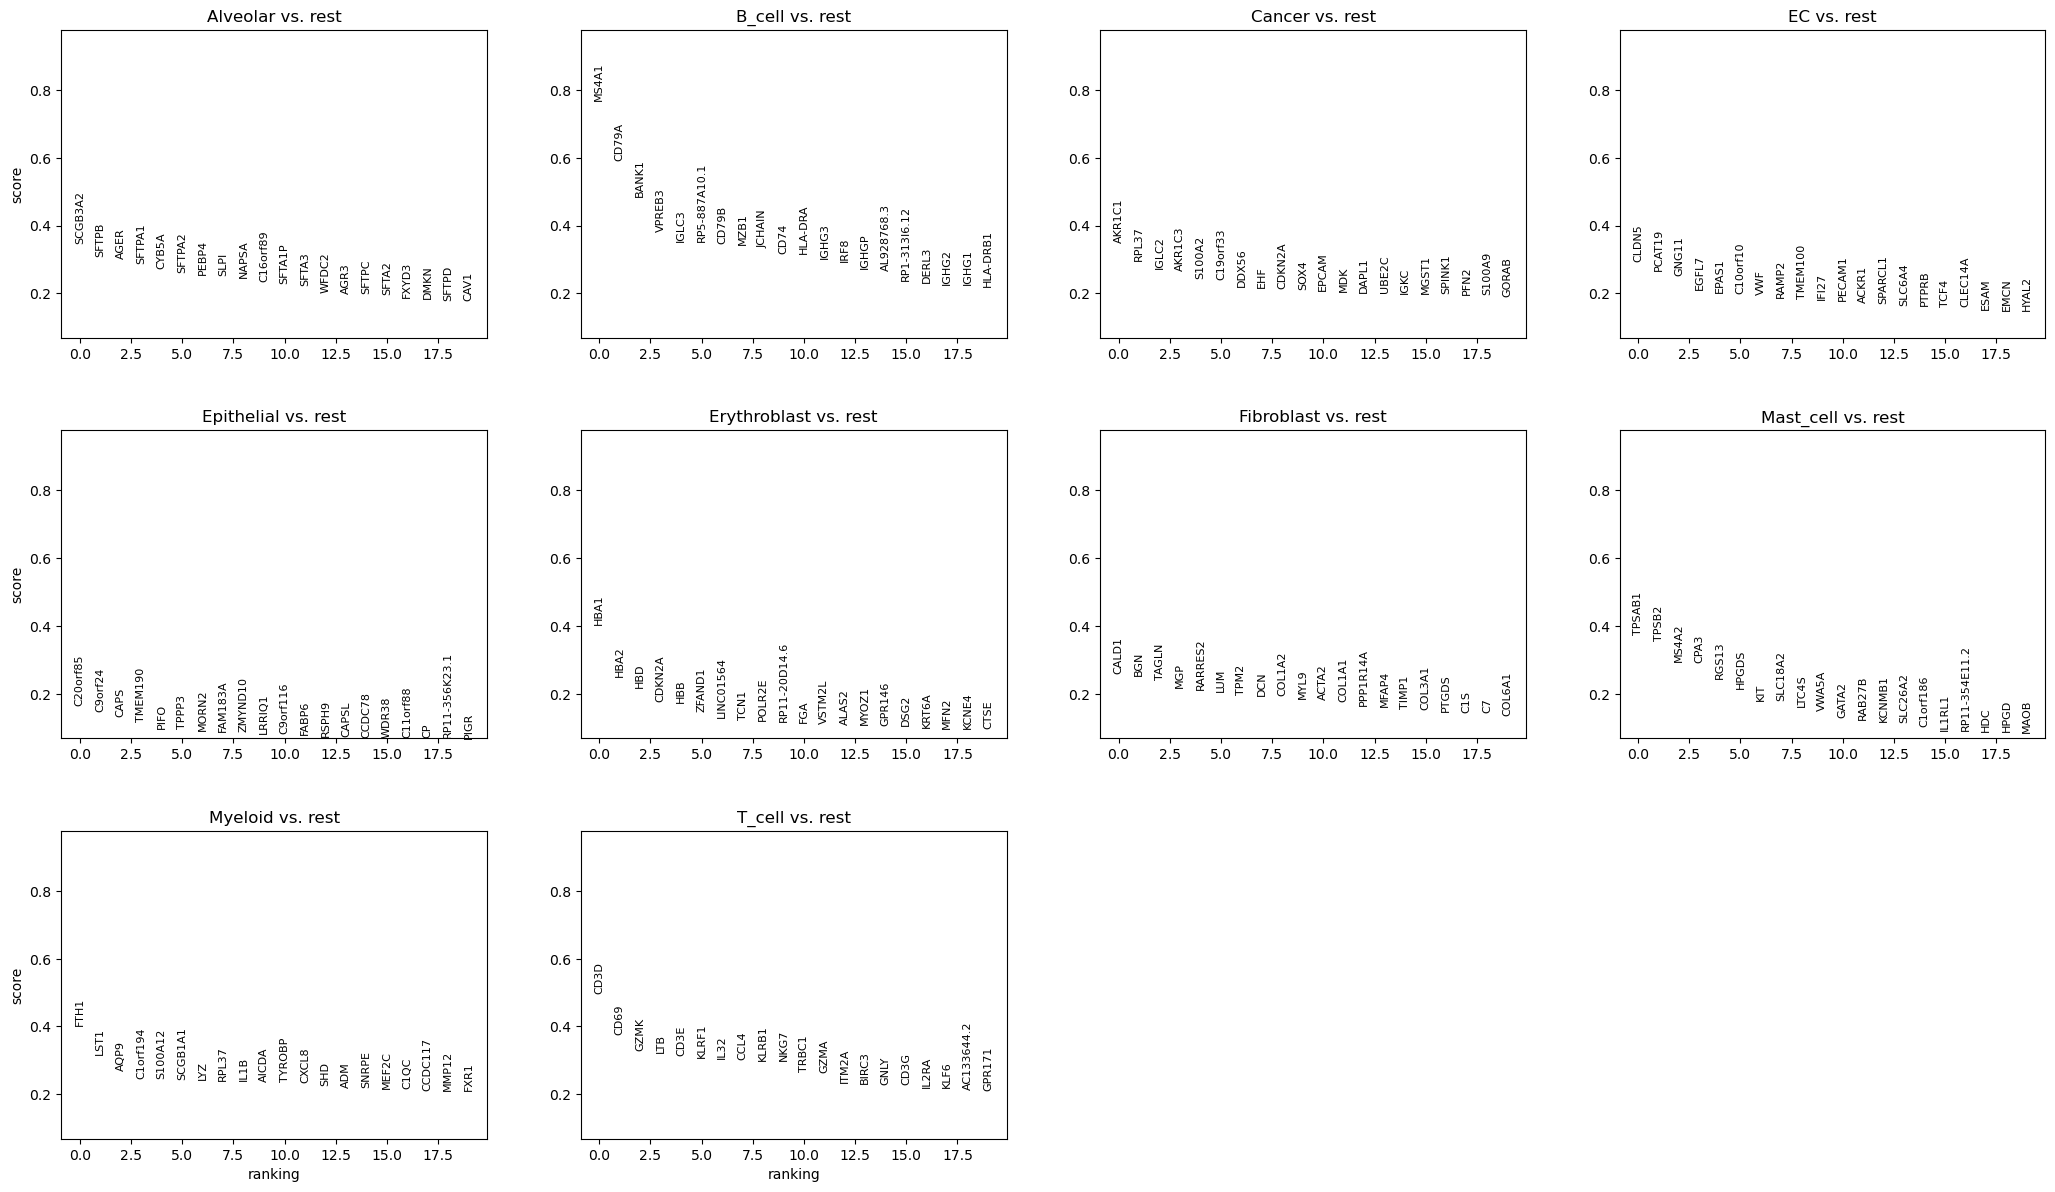

CPU times: user 928 ms, sys: 163 ms, total: 1.09 s
Wall time: 911 ms


In [46]:
%%time
sc.pl.rank_genes_groups(adata, n_genes=20)

In [47]:
post_time = time.time()

In [48]:
print("Total Postprocessing time: %s" % (post_time - preprocess_time))

Total Postprocessing time: 35.16312527656555


## Diffusion Maps

With cupy 9 its possible to compute Eigenvalues of sparse matrixes. We now create a Diffusion Map of the T-Cells to look at trajectories.

First we create a subset of only the T-Cells

In [49]:
tdata = adata[adata.obs["CellType"] == "T_cell", :].copy()

We can repeat the dimension reduction, clustering and visulatization.

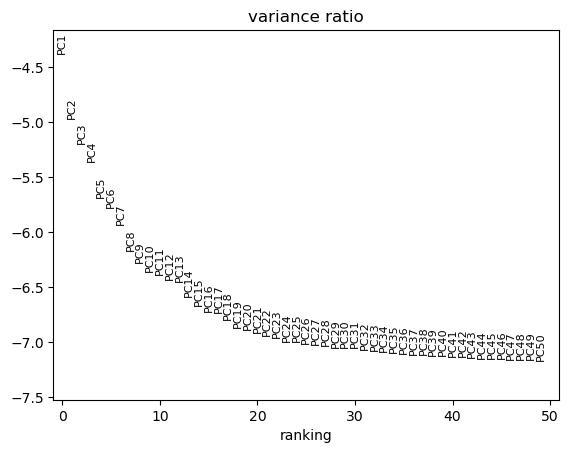

CPU times: user 903 ms, sys: 469 ms, total: 1.37 s
Wall time: 1.19 s


In [50]:
%%time
rsc.tl.pca(tdata, n_comps=50)
sc.pl.pca_variance_ratio(tdata, log=True, n_pcs=50)

In [51]:
%%time
rsc.pp.neighbors(tdata, n_neighbors=15, n_pcs=20)
rsc.tl.umap(tdata)
rsc.tl.louvain(tdata)

CPU times: user 353 ms, sys: 262 ms, total: 616 ms
Wall time: 617 ms


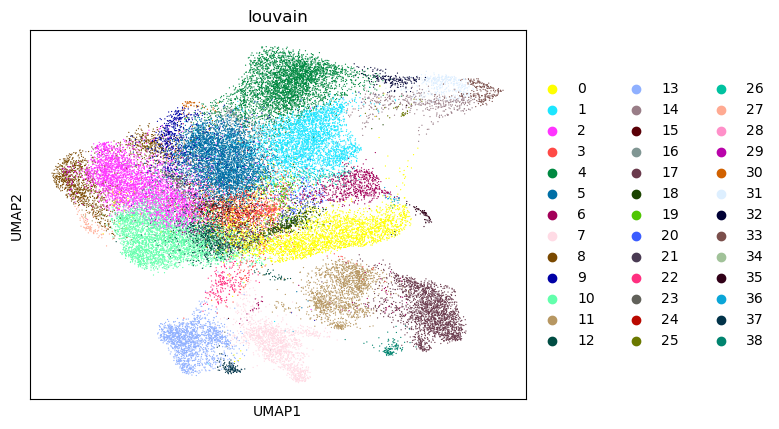

In [52]:
sc.pl.umap(tdata, color=["louvain"])

As stated before Diffusion Maps have become an integral part of single cell analysis.

In [53]:
%%time
rsc.tl.diffmap(tdata)

CPU times: user 371 ms, sys: 1.25 s, total: 1.62 s
Wall time: 175 ms


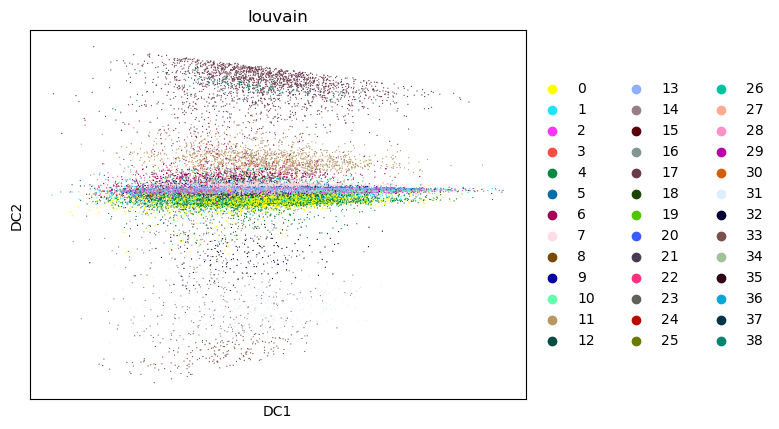

In [54]:
sc.pl.diffmap(tdata, color="louvain")

In [55]:
%%time
rsc.tl.draw_graph(tdata)

CPU times: user 337 ms, sys: 9.98 ms, total: 347 ms
Wall time: 349 ms


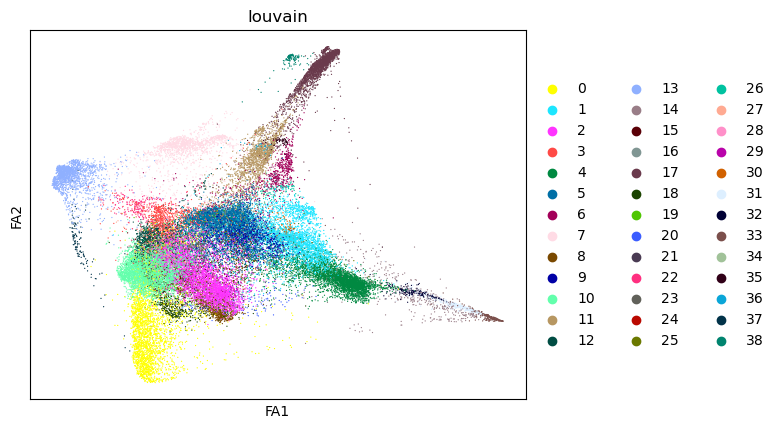

In [56]:
sc.pl.draw_graph(tdata, color="louvain")

After this you can use `X_diffmap` for `sc.pp.neighbors` and other functions. 

In [57]:
print("Total Processing time: %s" % (time.time() - preprocess_start))

Total Processing time: 47.36131834983826
